In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import squidpy as sq
import anndata as ad
import seaborn as sns
import simstpy as sim
import matplotlib.pyplot as plt
import h5py

In [17]:
SPATIAL_PATTERNS = [
    "human_DLPFC_151508",
    "human_DLPFC_151674",
    "mouse_cerebellum",
    "mouse_coronal_slices",
    "breast_tumor"
]

In [18]:
for log_fc in [0.5, 1, 1.5, 2]:
    for i, spatial_pattern in enumerate(SPATIAL_PATTERNS):
        df_spatial = sim.spatial.read_pattern(f"{spatial_pattern}")
        sim_adata= sim.rna.sim_multi_group(n_svgs=2,
                                           n_non_svgs=3,
                                           df_spatial=df_spatial,
                                           library_id=spatial_pattern,
                                           group_name="spatial_cluster",
                                           fold_change="fixed",
                                           log_fc=log_fc)
        

c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming

c:\Users\User\GPcounts\.venv\lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
c:\Users\User\GPcounts\.venv\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


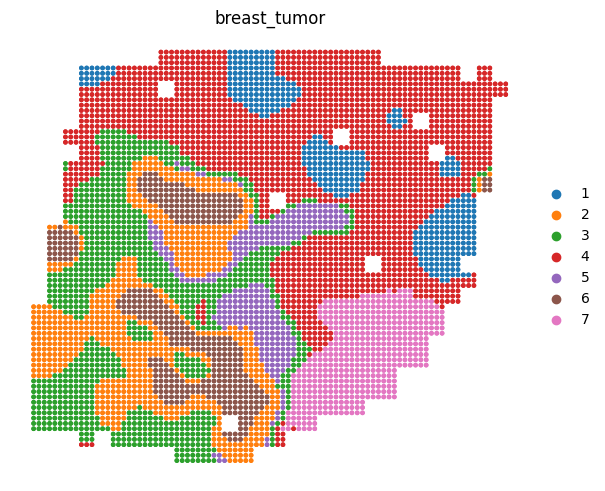

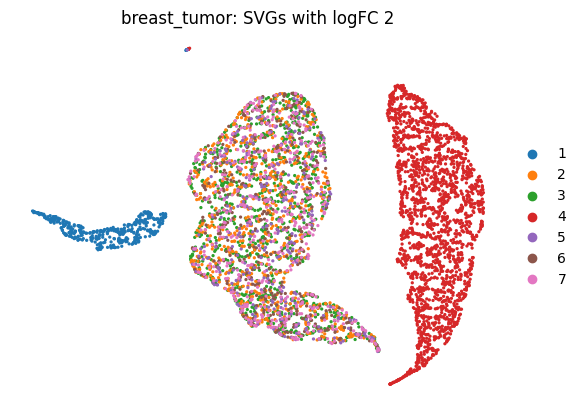

In [21]:
sc.pp.calculate_qc_metrics(sim_adata, percent_top=None, inplace=True)
sc.pp.filter_genes(sim_adata, min_cells=1)

sim_adata.layers['counts'] = sim_adata.X.copy()
sc.pp.normalize_total(sim_adata, target_sum=1e4)
sc.pp.log1p(sim_adata)

sq.pl.spatial_scatter(sim_adata, shape=None, color=["spatial_cluster"], title=spatial_pattern, frameon=False)

#sim.rna.compare_library_size(adata.layers['counts'], sim_adata.layers['counts'])

adata2 = sim_adata[:, sim_adata.var.spatially_variable]
sc.tl.pca(adata2, svd_solver='arpack')
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['spatial_cluster'], title=f"{spatial_pattern}: SVGs with logFC {log_fc}", frameon=False)

In [5]:
sim_adata.write_h5ad(f"{spatial_pattern}_logfc_{log_fc}.h5ad")


In [6]:
adata = sc.read_h5ad(r"C:\Users\User\GPcounts\GPcounts\demo_notebooks\breast_tumor_logfc_2.h5ad")

In [7]:
Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                        index=adata.obs_names, 
                        columns=adata.var_names)    

In [8]:
spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                     index=adata.obs_names, 
                                     columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

In [9]:
from GPcounts.RNA_seq_GP import rna_seq_gp
import statsmodels.formula.api as smf 
import statsmodels.api as sm

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.log())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf = pd.DataFrame(scales)
scalesdf = scalesdf.T

c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\User\AppData\Local\Temp\ipykernel_13360\4103162459.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = model.params[0]*spatial_locations['total_counts']
c:\Users\User\GPcounts\.venv\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead.

In [10]:
Y = Y.T
X = spatial_locations[['x', 'y']]

In [11]:
gp_counts = rna_seq_gp(X, Y, sparse=True, scale=scalesdf, safe_mode=False)

In [12]:
log_likelihood_ratio = gp_counts.One_sample_test("Negative_binomial")

  0%|          | 0/5 [00:00<?, ?it/s]

model 1 log likelihood = -9371.670639592892, alpha = None, km = 2.475965129613455e-06


 20%|██        | 1/5 [02:04<08:19, 124.81s/it]

results: [-9371.670639592892, -9442.592536670447, 70.9218970775546]
model 1 log likelihood = -10484.91822772471, alpha = None, km = 1.0628784491040833e-08


 40%|████      | 2/5 [05:07<07:57, 159.15s/it]

results: [-10484.91822772471, -10478.24975519023, -6.6684725344784965]
model 1 log likelihood = -10004.180365268187, alpha = None, km = 4.254872445230389e-10


 60%|██████    | 3/5 [07:03<04:38, 139.43s/it]

results: [-10004.180365268187, -9999.66238666288, -4.51797860530678]
model 1 log likelihood = -10778.239580880821, alpha = None, km = 3.471700794971199e-09


 80%|████████  | 4/5 [09:23<02:19, 139.36s/it]

results: [-10778.239580880821, -10771.517416997502, -6.7221638833198085]
model 1 log likelihood = -10417.901948446402, alpha = None, km = 2.2549632302967766e-09


100%|██████████| 5/5 [13:39<00:00, 163.80s/it]

results: [-10417.901948446402, -10412.232700451548, -5.669247994854231]


In [15]:
df = gp_counts.calculate_FDR(log_likelihood_ratio)

c:\Users\User\GPcounts\.venv\lib\site-packages\GPcounts\RNA_seq_GP.py:420: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


In [16]:
df

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
gene_0,-9371.670640,-9442.592537,70.921897,0.0,0.0
gene_1,-10484.918228,-10478.249755,-6.668473,1.0,1.0
gene_2,-10004.180365,-9999.662387,-4.517979,1.0,1.0
gene_3,-10778.239581,-10771.517417,-6.722164,1.0,1.0
gene_4,-10417.901948,-10412.232700,-5.669248,1.0,1.0
